In [33]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import astropy
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from scipy import optimize
import math

In [2]:
#Setting given conditions and constants
peak_abs_mag = -19.5
kappa = 0
omega_r = 0
c = (const.c.to('km/s'))

#Read in data
dataframe = pd.read_csv('SNe_Scattergood.csv')
print(dataframe.head())

   Redshift   AppMag  DAppMag
0    0.2604  21.0399   0.1436
1    0.1636  19.8173   0.0547
2    0.2986  21.2489   0.1899
3    0.1777  19.9634   0.0651
4    0.2170  20.3851   0.0986


In [3]:
#Convert dataframe columns to numpy arrays 
def pd_to_np_array(dataframe, col):
    """
    Converts an input dataframe column to a numpy array 

    Parameters:
    - dataframe: Series, pandas dataframe to read data from
    - col: Str, Name of dataframe column to convert

    Returns:
    - numpy array of column data 
    """
    
    return dataframe[col].to_numpy()

In [46]:
#Use above function to create numpy arrays of each column 
Z = pd_to_np_array(dataframe, "Redshift")
app_mag = pd_to_np_array(dataframe,"AppMag")
app_mag_error = pd_to_np_array(dataframe,"DAppMag")

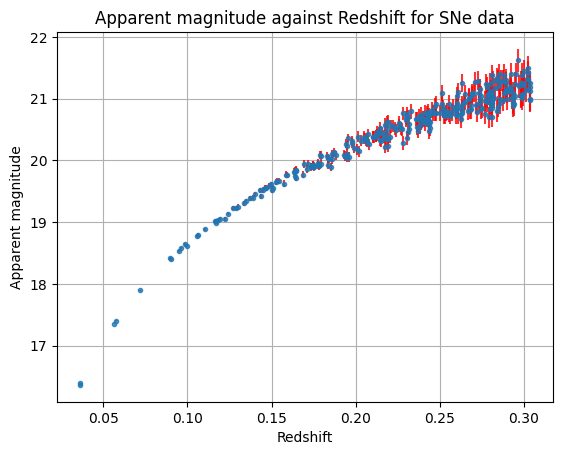

In [5]:
fig, axis = plt.subplots()

#plot Redshift against Apparent magnitude with error bars
plt.errorbar(Z, app_mag, yerr=app_mag_error, fmt='.', ecolor='r', alpha=0.8)

#Figure labelling
plt.ylabel('Apparent magnitude')
plt.xlabel('Redshift')
plt.title('Apparent magnitude against Redshift for SNe data')
plt.grid()

plt.show()

The relation between luminosity distance, $d_L$, apparent magnitude, m,  and absolute magnitude, M, is given by:

$$
M = m − 5log10(d_L) + 5
$$

Which can be rearranged for $d_L$:

$$
 d_L= 10^{\frac{m-M+5}{5}}
$$

In [6]:
#def luminosity_distance():
 #   '''
#
 #   '''
  #  lum_dis_pc = (10**((m - peak_abs_mag + 5)/5))* u.pc

In [97]:
#Use the lowest redshift SNe to determine a value for the hubble parameter

# Retrieve apparent magnitude value correspnding to lowest Redshift value 
m = dataframe.loc[dataframe['Redshift'].idxmin()]['AppMag']

#Calculate luminosity distance in units of Mpc
lum_dis_Z_min = (10**((m - peak_abs_mag + 5)/5))/1000000 * u.Mpc

#Format to 3 decimal places
#lum_dis_Z_min = "{:.3f}".format(lum_dis_Z_min)

print(f"{lum_dis_Z_min:.3f}")

148.929 Mpc


Convert luminosity distance to proper distance using:
$$
d_p = \frac{d_L}{(1+Z)}
$$

Hubble constant can be calculated using the following equation:
$$
H_0 = \frac{c z}{d_p}
$$

Where c is the speed of light, and z is redshift 

In [98]:
print(f"Lowest redshift value in dataframe: {Z.min()}")

# calculate proper distance using above equation, lowest redshift value and luminosity distance calculated in above cell 

print(f'Luminosity distance is {lum_dis_Z_min:.3f}')

proper_dis = lum_dis_Z_min/(1+Z.min())
print(f'Proper distance is {proper_dis:.3f}')

H_0 = (c*Z.min())/proper_dis

print(f"H_0 is {H_0:.3f}") 

Lowest redshift value in dataframe: 0.0359
Luminosity distance is 148.929 Mpc
Proper distance is 143.768 Mpc
H_0 is 74.861 km / (Mpc s)


In [53]:
#Calculate luminosity distance (in pc) for all SNe in dataset by passing in app_mag numpy array from 4th cell
lum_dis_all_pc = (10**((app_mag - peak_abs_mag + 5)/5)* u.pc)

# convert to Mpc
lum_dis_all_mpc = lum_dis_all_pc.to(u.Mpc)

#append values to dataframe for accessibility use
dataframe['Lum_dis[Mpc]'] = lum_dis_all_mpc.value.tolist()
print(dataframe.head())


   Redshift   AppMag  DAppMag  Lum_dis[Mpc]
0    0.2604  21.0399   0.1436   1282.271531
1    0.1636  19.8173   0.0547    730.230553
2    0.2986  21.2489   0.1899   1411.822178
3    0.1777  19.9634   0.0651    781.052092
4    0.2170  20.3851   0.0986    948.462141


In [99]:
# Set cosmological conditions for omega matter, omega dark energy and hubble constant 
conditions = FlatLambdaCDM(H0=H_0, Om0=0.5)

# Calculate luminosity conditions for given cosmological conditions at maximum redshift
dl = conditions.luminosity_distance(Z.max())
print(f'Luminosity distance with H_0={H_0:.3f} and when both omega matter and omega dark energy are 0.5 is: {dl:.3f}')

Luminosity distance with H_0=74.861 km / (Mpc s) and when both omega matter and omega dark energy are 0.5 is: 1413.912 Mpc


In [100]:
# Create an array from 0.01 to Z_max (inclusive) in increments of 10^-3
Z_array = np.arange(0.01, Z.max() + 10**-3, 10**-3)

# Use luminosity distance function of cosmology package on Z_array
lum_dis_array = np.array(conditions.luminosity_distance(Z_array))* 10**6 # in pc

Given that:
$$
M = m -5 log_{10}(d_L) + 5
$$

Rearranging for apparent magnitude:

$$
m = M + 5log{(d_L)} - 5
$$

In [102]:
#Calculate the apparent magnitudes using the luminosity distance array from the cell above 
apparent_magnitude_array = peak_abs_mag +  5*np.log10(lum_dis_array) - 5

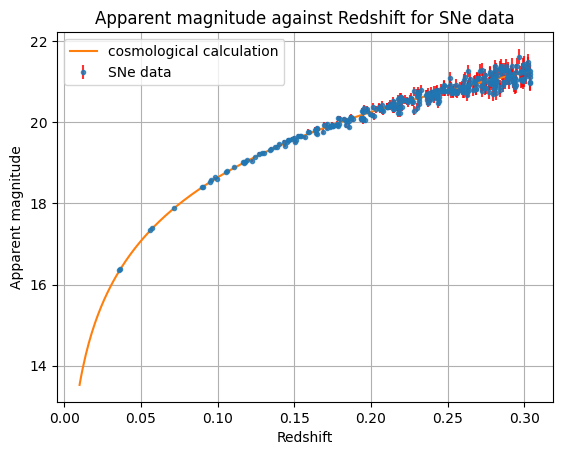

In [19]:
plt.errorbar(Z, app_mag, yerr=app_mag_error, fmt='.', ecolor='r', alpha=0.8, label="SNe data")
plt.plot(Z_array, apparent_magnitude_array, label="cosmological calculation")
#plt.errorbar(Z_array, apparent_magnitude_array, yerr=app_mag_error, fmt=".", ecolor="b", alpha=0.8, label="cosmological calculation")

plt.ylabel('Apparent magnitude')
plt.xlabel('Redshift')
plt.title('Apparent magnitude against Redshift for SNe data')

plt.legend()
plt.grid()
plt.show()

In [104]:
def apparent_magnitude(xdata, H, omega_m):
    """
    A function that takes cosmological parameters, calculates luminosity distance and returns a numpy array of apparent magnitude values

    Parameters:
     - xdata: array, 
     - H: float, Hubble's constant
     - omega_m: float, matter density of the unvierse 
    
     Returns
     - apparent_magnitude_array, a numpy array of apparent magnitudes corresponding to various redshifts
    """

    cosmology = FlatLambdaCDM(H0=H, Om0=omega_m)
    luminosity_distance_array = np.array(cosmology.luminosity_distance(xdata))* 10**6
    apparent_magnitude_array = peak_abs_mag +  5*np.log10(luminosity_distance_array) - 5

    return apparent_magnitude_array

In [105]:
Z_array_300 = np.linspace(0.01, Z.max(), 300)
popt, pcov = optimize.curve_fit(apparent_magnitude, Z, app_mag, p0=[H_0.value, 0.5], bounds=(0, [np.inf, 1]))
perr = np.sqrt(np.diag(pcov))

print(f"Ideal hubble pararmeter value is: {popt[0]:.3f} +- {perr[0]:.3f}")
print(f"Ideal Omega m value is: {popt[1]:.3f} +- {perr[1]:.3f}")

Ideal hubble pararmeter value is: 74.144 +- 1.080
Ideal Omega m value is: 0.578 +- 0.098


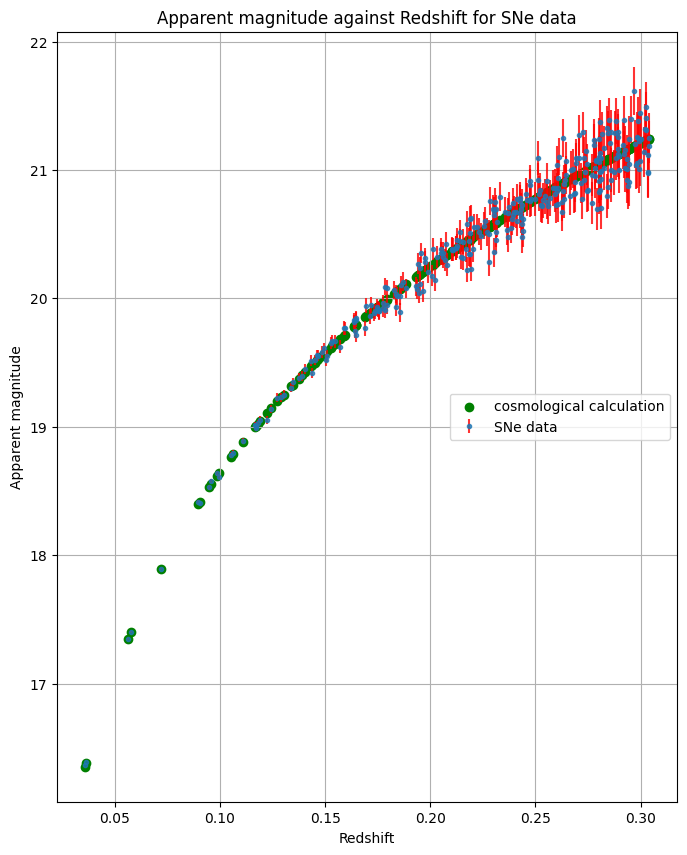

In [109]:
fig, ax = plt.subplots(figsize=(8,10))

ideal_app_mag = apparent_magnitude(Z, popt[0], popt[1]) 

plt.errorbar(Z, app_mag, yerr=app_mag_error, fmt='.', ecolor='r', alpha=0.8, label="SNe data")
plt.scatter(Z, ideal_app_mag, label="cosmological calculation", color="green")

    
plt.ylabel('Apparent magnitude')
plt.xlabel('Redshift')
plt.title('Apparent magnitude against Redshift for SNe data')


plt.legend(loc="center right")
plt.grid()
plt.show()